# **Homework 7:** Convolutional Neural Networks

### Collaborators

Huaze Liu

LIST COLLABORATORS HERE

# Part 0: Enviornment Setup

#### This is the same as the previous homework

For this homework and for the final project, you may find it useful to run your code with access to a sufficient GPU, which may allow your code to run faster (we will talk about why later in the course). If you do not have access to a powerful GPU on your personal computer (e.g. if you primarily use a laptop), then there are 2 options you may consider for using a remotely hosted GPU.

*Note that some laptops may actually run this code faster than the course server, so you may want to try it first on your laptop regardless*

In [ ]:
# This is the path that the dataset for this homework will be downloaded to. 
# If you are running on the course server or Colab you can keep this line, if you are
# running on a personal computer, you may want to change this location.
from hw7_support import *
data_path = '/cs/cs152/data'
import numpy as np
import matplotlib.pyplot as plt


## Option 1: Use the course GPU server



We have a GPU server available for this course that you all should have access to. (If you are not a Mudd student we may need to get you setup with a Mudd CS account). The server name is `teapot.cs.hmc.edu`.

You can login to the server via a terminal using your hmc username and password:

`ssh <USERNAME>@teapot.ssh.hmc.edu`

Then run the command:

`source /cs/cs152/venv/bin/activate` 

to activate the course Python enviornment, followed by:

`jupyter lab --no-browser`

to start a Jupyter server (if you want to keep a server running you can use [tmux](https://www.redhat.com/sysadmin/introduction-tmux-linux)). At the end of the Jupyter startup output you should see a line like this:

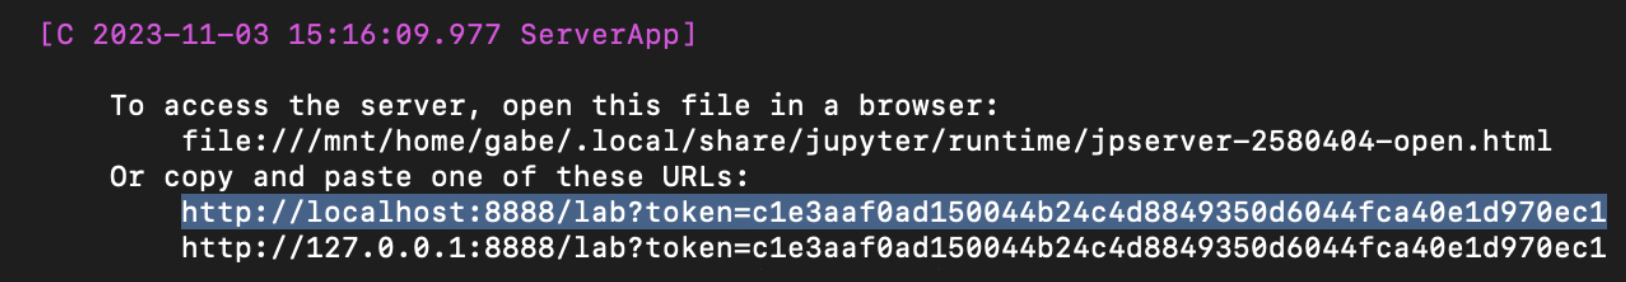



This tells us the port and password we need to access the server remotely. In order to access the server we'll start an ssh tunnel. Open a new terminal window and run the command:

`ssh -L 9000:localhost:<PORT> <USERNAME>@teapot.cs.hmc.edu`

Where `<PORT>` is the port output from JupyterLab above (`8888` in the example image). `9000` is a local network port for your compute to access the server. If `9000` is in use, you can change the number to something different. Once the ssh tunnel is running you can access the notebook server by navigating to `http://localhost:9000/lab` in a web browser.

You can also setup VSCode to connect to this server. At the top right of the window click the kernel menu:

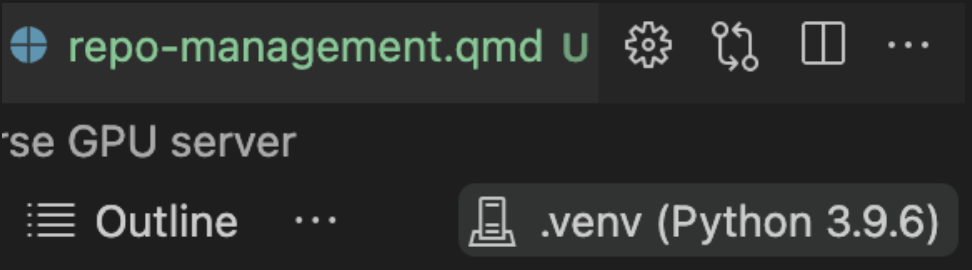


You should see the following popup:

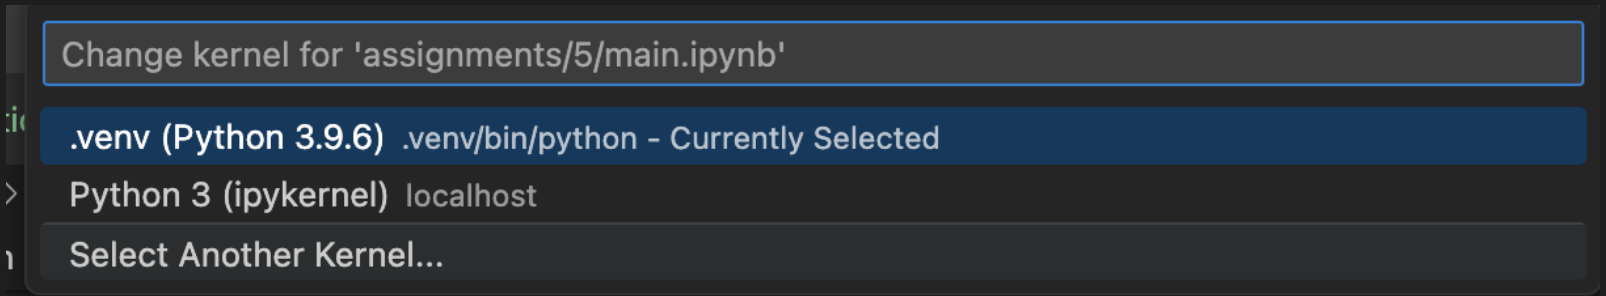


Click `Select another kernel`, then `Existing Jupyter Server` and paste the address from above:
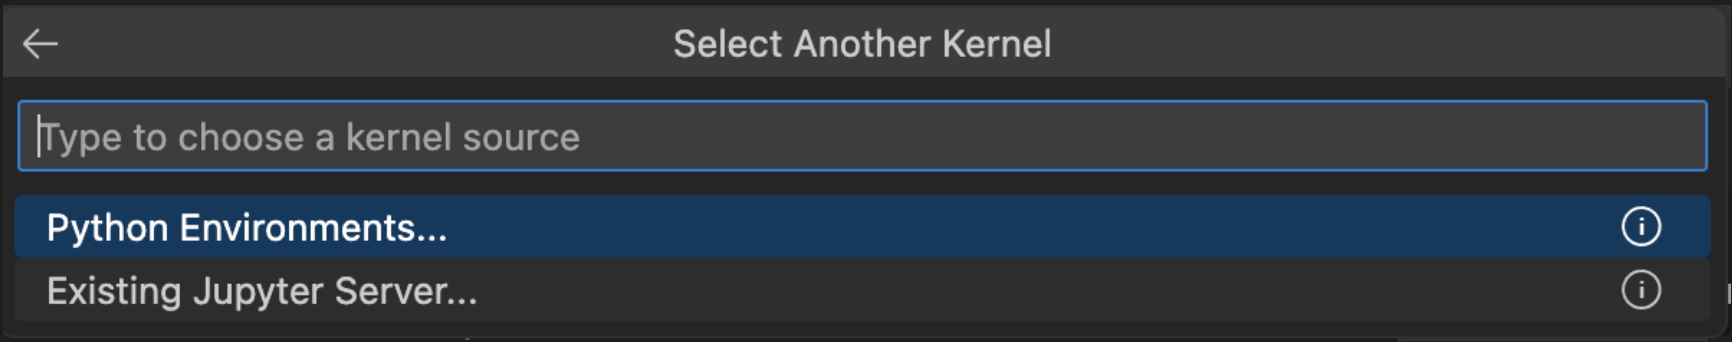
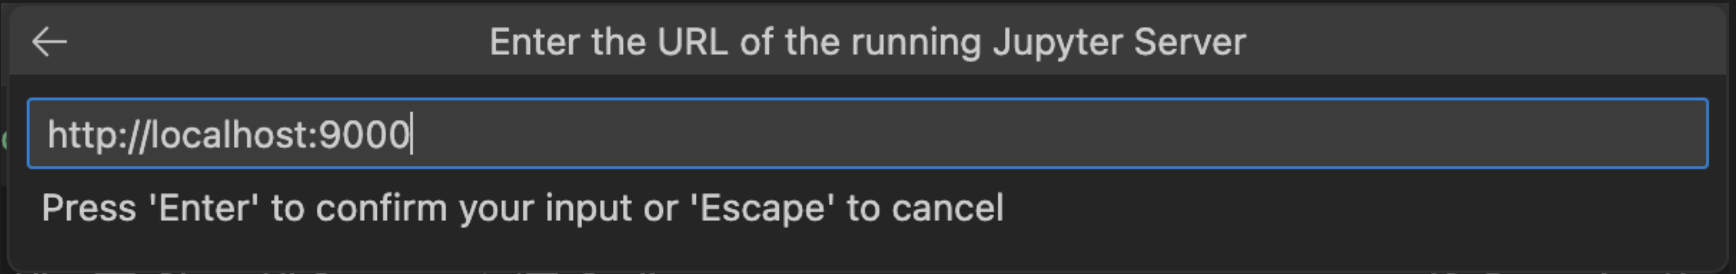

Paste the token from the Jupyter output when prompted for a password. If given multiple kernel options, select `Python3`. You should now be running the notebook code remotely!

## Option 2: Google Colab



If you are unable to get the course server to work, another option is to use Google's Colab service which provides a simple way to run GPU-accelerated Jupyter notebooks on the web.

To start, go to: `https://colab.research.google.com/`

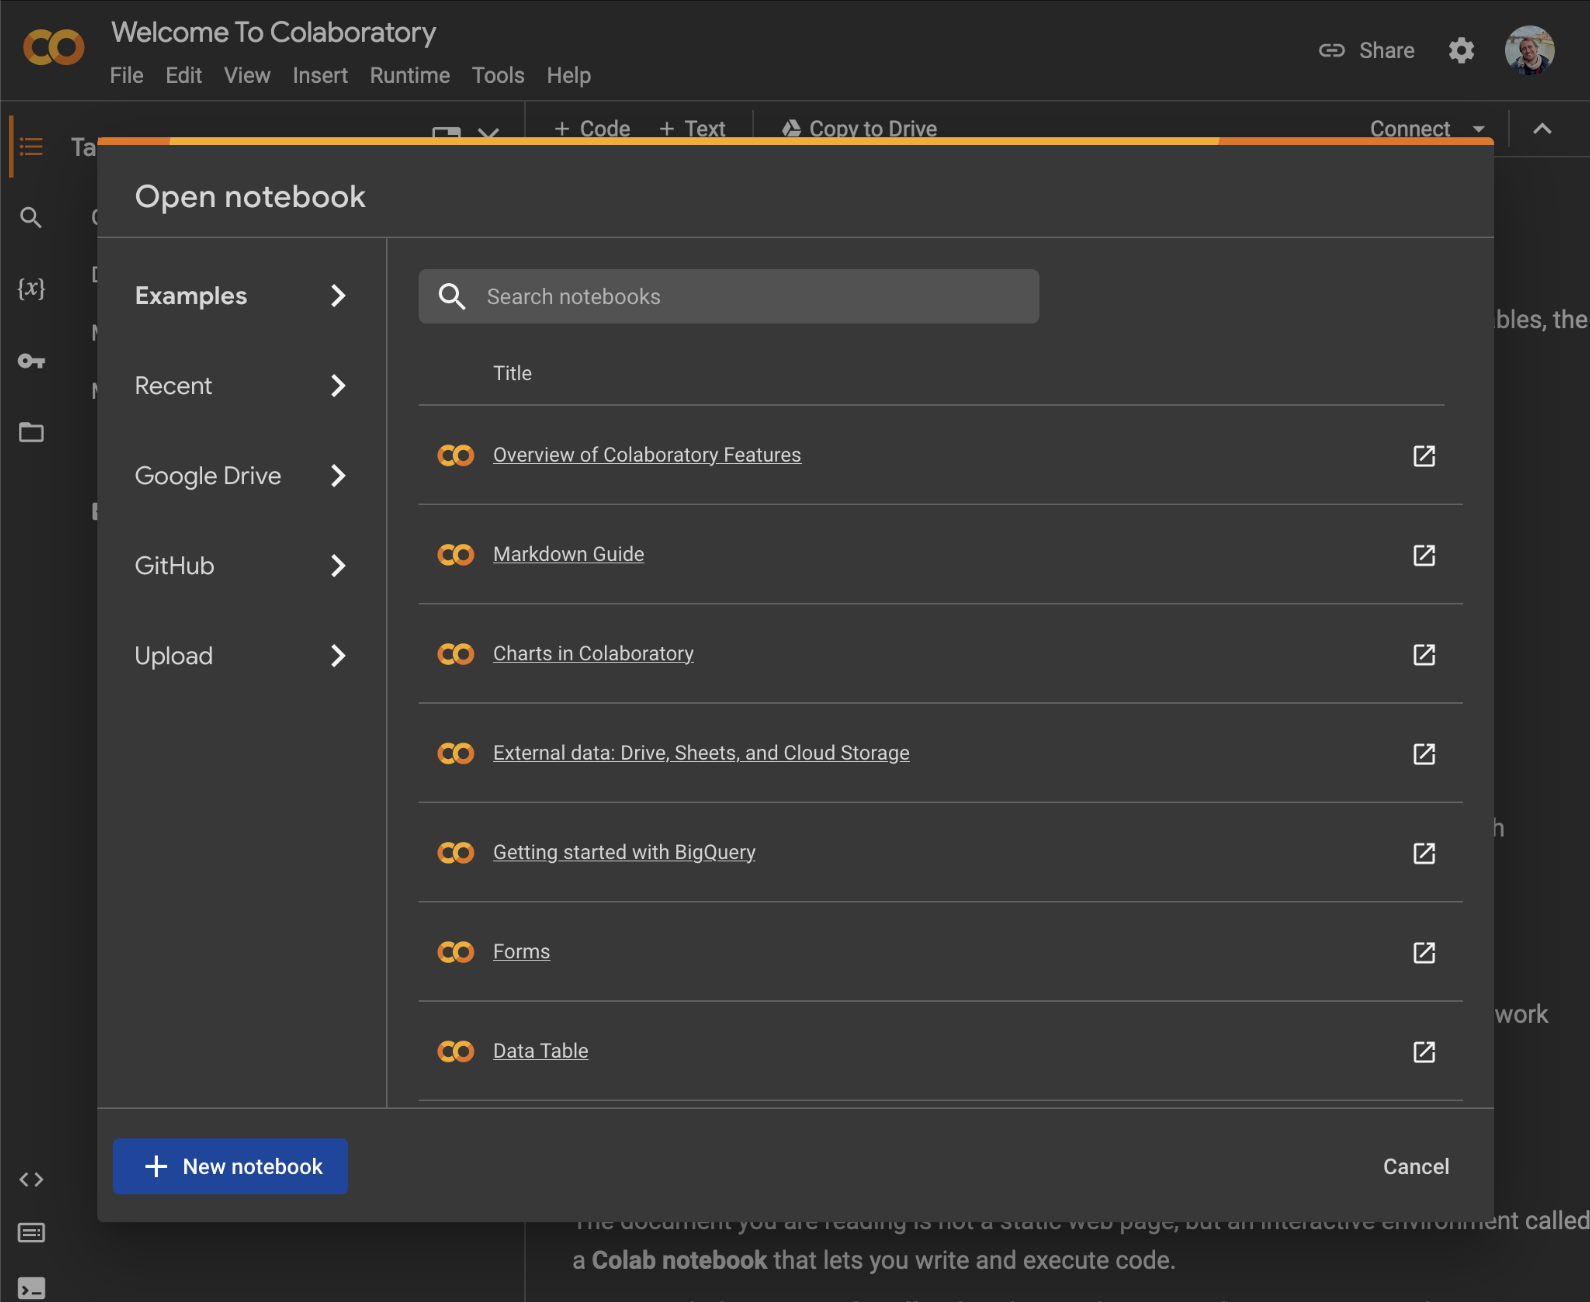

Upload this notebook by either going to the upload tab on the welcome screen or selecting `file->upload notebook` in the top menu.

Once you open the notebook, you'll want to add a GPU. To do this navigate to `runtime->change runtime type` in the top menu.

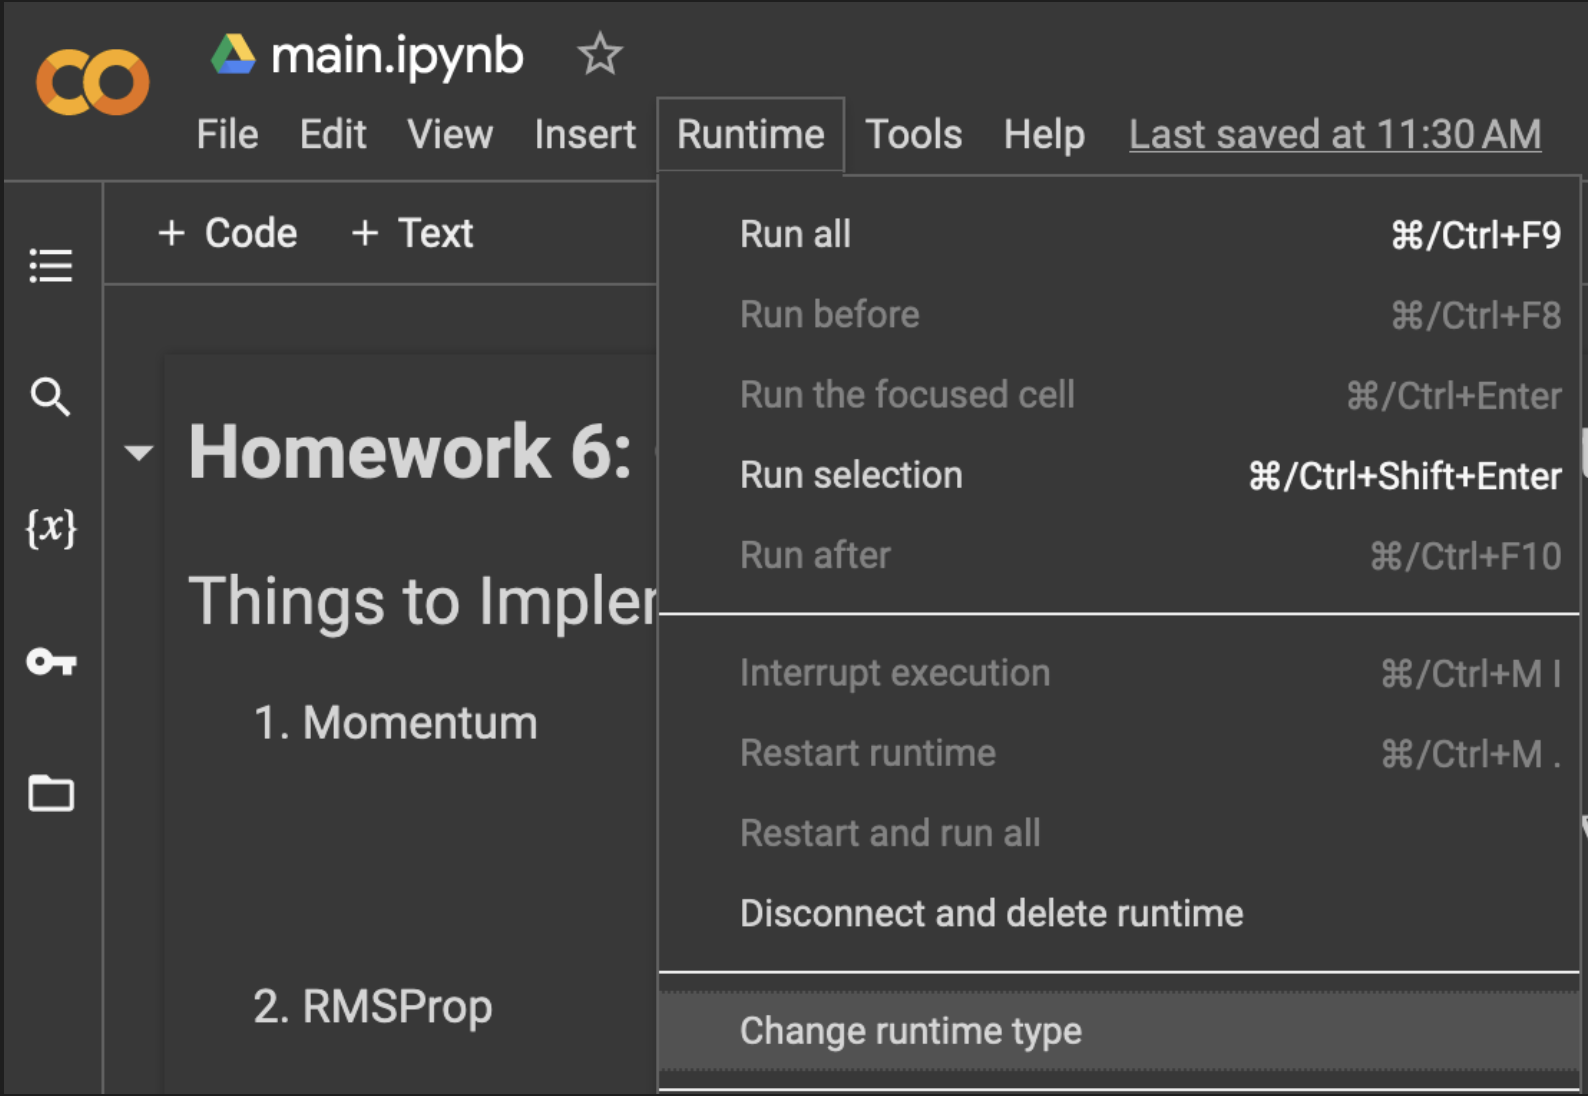

In the popup menu select `T4 GPU` and click save.

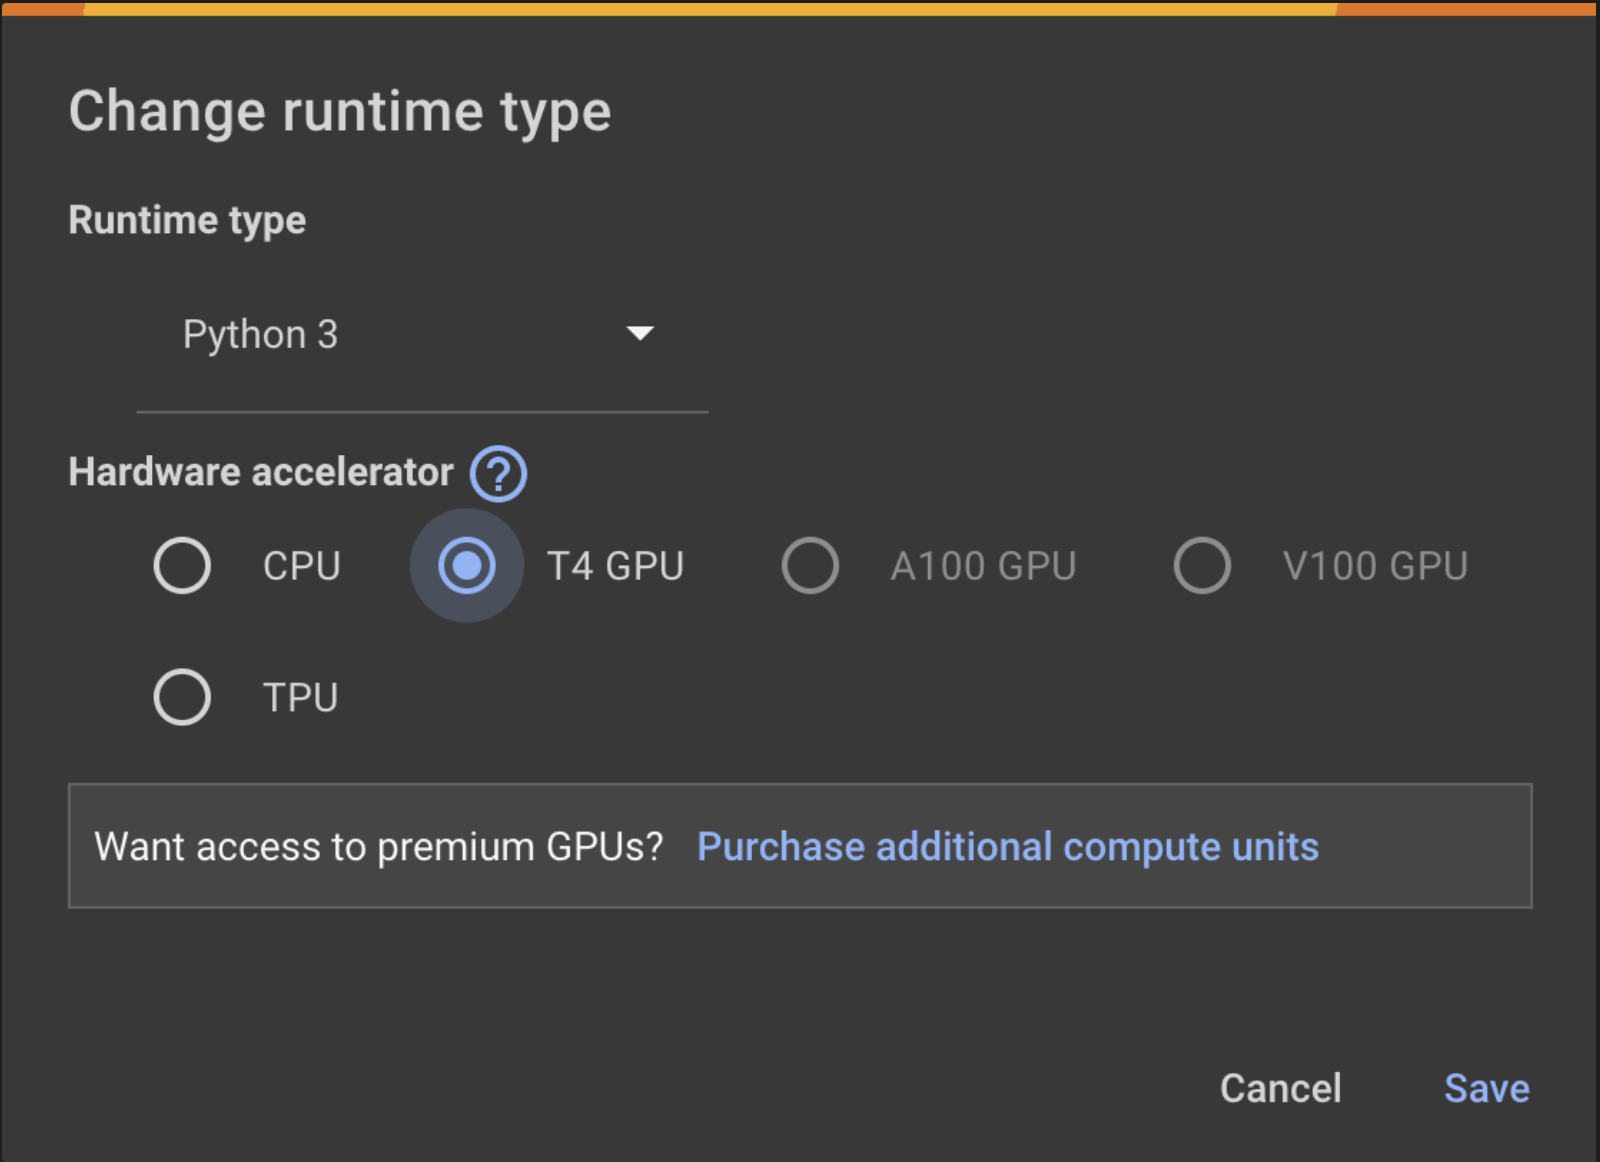
Now you should be able to run the notebook! Once you've completed the assignment, you can download the notebook to submit it as usual.

# Part 1: Convolutions

Recall from class that a *convolution* can be thought of as a moving dot product between a *kernel* vector or matrix and an *input* vector or matrix. (Note: technically the operation we're defining here is a *discrete cross-correlation*, not a convolution, but the names are often used interchangably). In particular, a 1-dimensional convolution is an operation between an input vector $\mathbf{x}$ and a kernel $\mathbf{k}$, such that each entry of the output vector $\mathbf{c}$ is defined by centering $\mathbf{k}$ at an entry of $\mathbf{x}$, multiplying the aligning elements and taking the sum of the results as in the following animation:





<video src="convolution_basic.mp4" controls title="Title" height=320 style="margin:auto;"></video>

Note that without padding, we only consider locations for the kernel where every entry aligns with an entry from the input, resulting in an output that is shorter than the input.

#### **Q1**

Find the result of taking the convolution of the following input and kernel (by hand), using the approach shown above.

$$\text{Input: } \begin{bmatrix}2 & 3 & -1 & 5 & -2 \end{bmatrix}$$
$$\text{Kernel: } \begin{bmatrix} 1 & 2 & 1 \end{bmatrix}$$

YOUR ANSWER HERE

Unfortunately, this notion of "centering" the kernel at each location doesn't work if our kernel is an even size. Instead, we need a general formula. We'll define output $i$ of our convolution to be:

$$\text{Conv}(\mathbf{x}, \mathbf{k})_i = \sum_{j=1}^s x_{i+j} k_j$$


We'll use the following convention for the size of the input and kernel:
$$ \text{Input size: } d$$
$$ \text{Kernel size: } s$$

#### **Q2**

Verify that the equation above gives the same result for the input and kernel in *Q1* (write out the formula for each entry of the result).

YOUR ANSWER HERE

#### **Q3**

Looking at the convolution equation above, what is the length of the output in terms of $d$ and $s$? Note that without padding, the length of the output will be determined by the maximum value of $i$, such that $x_{i+j}$ is a valid entry of $x$ for all terms in the summation (i.e. $i+j \leq d$).

YOUR ANSWER HERE

#### **Q4:**

Complete the 1-dimensional convolution function below using the formula for the output length you just defined and the convolution formula. Do not use a convolution function from a Python library such as SciPy or PyTorch.

*Feel free to use Python loops, as we won't actually train with this implementation, so performance doesn't matter!*

In [ ]:
def conv1d(sequence, kernel):
    kernel_size = kernel.shape[0]
    sequence_length = sequence.shape[0]
    output_length = # YOUR CODE HERE
    
    output = np.zeros((output_length,))
    # YOUR CODE HERE
    return output

Now we'll try out our convolution on a sequence of data! Below, we'll create an arbitrary input sequence and apply a kernel to it using the convolution function we just wrote. If you're curious, try changing the kernel and see how the result changes!

In [ ]:
# Create a domain to create our input
x = np.linspace(-5, 5, 25)

# Create an sequence
signal = np.sin(x * 1.5) + np.cos(x / 2) + np.cos(x / 1.3 + 2)

# Create a kernel for our convolution
kernel = np.array([-1, 1, -1])

# Plot the input, kernel and the result of the convolution
f, ax = plt.subplots(1, 3, figsize=(7, 2))
ax[0].plot(signal)
ax[0].set_title('Input')
ax[1].plot(kernel)
ax[1].set_title('Kernel')
ax[2].plot(conv1d(signal, kernel))
ax[2].set_title('Convolved')


Now let's define how to compute derivatives of convolutions. We'll start by defining $\mathbf{c} = \text{Conv}(\mathbf{x}, \mathbf{k})$ to be the output of our convolution and $\frac{dL}{d\mathbf{c}}$ to be the gradient of a (scalar) loss with respect to $\mathbf{c}$. We could compute the derivative with respect to each entry in the input $(x_{j})$ or kernel $(k_{j})$ by applying the chain rule using every entry in $\mathbf{c}$, $(C_{i})$ and summing the results:

$$\frac{dL}{dx_{j}} = \sum_{i=1}^d \frac{dL}{dc_{i}}\frac{dc_{i}}{dx_{j}}$$
$$\frac{dL}{dk_{j}} = \sum_{i=1}^d  \frac{dL}{dc_{i}}\frac{dc_{i}}{dk_{j}}$$

Note that, because of the convolutional structure, each entry of the output only depends on a few entries of the input. If $c_i$ does not depend on $x_j$, then $\frac{dc_i}{dx_j}$ will be 0. Consider the gradient animation we saw in class.


<video src="convolution_derivative.mp4" controls height=320 title="Title"></video>

A more efficient way to think about computing these derivatives is to consider the gradient updates that correspond to each update of our output. If we update:

$$c_{i} \longleftarrow c_{i} + x_{i+j}\ k_{j}$$
Then in our backward pass of automatic differentiation, we will need to update:
$$\frac{dL}{dx_{i+j}} \longleftarrow \frac{dL}{dx_{i+j}} +\frac{dL}{dc_{i}} \frac{dc_i}{dx_{i+j}}$$
$$\frac{dL}{dk_{j}} \longleftarrow \frac{dL}{dk_{j}} +\frac{dL}{dc_{i}} \frac{dc_i}{dk_{j}}$$

#### **Q5**

Modify your `conv1d` function to compute the gradient of the loss with respect to both the input $(\mathbf{x})$ and the kernel $(\mathbf{k})$. The function will now take an additional argument that specifies $\frac{dL}{d\mathbf{c}}$, the gradient of the loss $(L)$ with respect the output of the convolution $(\mathbf{c})$.

***Hint:** If you used loops to implement `conv1d` you can keep the same structure, each time you would update an entry of the output $\mathbf{c}$, update the appropriate entries of $\frac{dL}{dx_{i+j}}$ and $\frac{dL}{dk_{j}}$ instead as shown above.*

In [ ]:
def conv1d_backward(sequence, kernel, dloss_doutput):
    kernel_size = kernel.shape[0]
    sequence_length = sequence.shape[0]
    output_length = dloss_doutput.shape[0]
    
    dloss_dsequence = np.zeros_like(sequence)
    dloss_dkernel = np.zeros_like(kernel)
    
    # YOUR CODE HERE    

    return dloss_dsequence, dloss_dkernel

A 2-dimensional convolution generalizes the idea of a convolution to matrices, as shown in the following animation ([credit](https://arxiv.org/abs/1603.07285)).

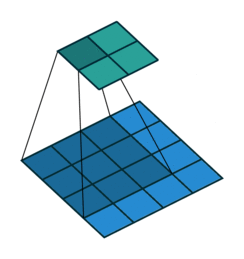

In this case we assume both the input $\mathbf{X}$ and kernel $\mathbf{K}$ are matricies of size $(d \times e)$ and $(s \times s)$ respectively:
$$\text{Input }\mathbf{X}: d \times e \text{ matrix}$$
$$\text{Kernel }\mathbf{K}: s \times s \text{ matrix}$$

*Note: we're assuming for simplcity that $\mathbf{K}$ is square, but this need not be the case in general.*

In this case, we move our 2-dimensional kernel to every possible location in the input and once again multiply corresponding elements, taking the sum. We can summarize this in a similar equation:

$$\text{Conv}(\mathbf{X}, \mathbf{K})_{r,c} =  \sum_{i=1}^s\sum_{j=1}^s X_{r+i,c+j}\ K_{i,j}$$

#### **Q6:**

Complete the following implementation of a 2-dimensional convolution. using the equation above. As before, you'll need to determine the correct output size first.

*Once again, performance doesn't matter here*

In [ ]:
def conv2d(image, kernel):
    kernel_size = kernel.shape[0]
    image_height, image_width = image.shape[0], image.shape[1]
    output_height = # YOUR CODE HERE
    output_width = # YOUR CODE HERE

    output = np.zeros((output_height, output_width))
    # YOUR CODE HERE
    
    return output

Let's try out our `conv2d` function on an image. As we've used in previous homeworks, we can use PyTorch to load a variety of real datasets. For image datasets, these are available in the `torchvision` library. We can download the MNIST dataset of number images that we've used before with the following code:

In [ ]:
import torchvision
data = torchvision.datasets.MNIST(data_path,       # Specify where to store the data
                                  download=True,   # Whether to download the data if we don't have it
                                  train=True       # Download the training set (False will download the validation set)
                                  )
print(data[0])

We see that in the above if we take an observation from this dataset we get a tuple of an image and a corresponding label. The image is given as an object from the Pillow library (`PIL`). 

In [ ]:
data[0][0]

We can convert Pillow images to torch tensors using a `torchvision.transforms.ToTensor` object, or we can pass such an object directly to the dataset class to transform our data automatically.

In [ ]:
# Create a transform object
transform = torchvision.transforms.ToTensor()

# Apply the transform to the first image in the dataset (ignoring the label)
image = transform(data[0][0])
print('Converted image type:', type(image))

# Give the transform directly to the MNIST object
data = torchvision.datasets.MNIST(data_path, transform=transform)
print('Automatically converted image type:', type(data[0][0]))
print('Image shape:', data[0][0].shape)


If we look at the shape of an image, we see that it has height and width dimensions, but also an extra dimension. This is the *color channel dimension*. Since these are greyscale images with only a single color channel we'll get rid of it for now.

In [ ]:
# Take just the height and width dimensions of our image
image = data[0][0][0]
image.shape

Fianlly let's apply a few different kernels to the image and visualize the results.

In [ ]:
# Create an edge detection kernel
kernel = np.array([[ 1,  1,  1],
                   [ 0,  0,  0],
                   [-1, -1, -1]])

# Create the axes for our plots
f, ax = plt.subplots(2, 4, figsize=(8, 4))
ax[0, 0].imshow(image, cmap='Greys_r')
ax[0, 0].set_title('Image')

# Apply our convolution and plot the result
output = conv2d(image, kernel)
ax[0, 1].imshow(output, cmap='Greys_r')
ax[0, 1].set_title('Vertical edges')
ax[1, 1].imshow(kernel, cmap='Greys_r')

# Apply our transposed convolution and plot the result
output = conv2d(image, kernel.T)
ax[0, 2].imshow(output, cmap='Greys_r')
ax[0, 2].set_title('Horizontal edges')
ax[1, 2].imshow(kernel.T, cmap='Greys_r')

# Apply a kernel of all 1s to blur the image
output = conv2d(image, np.ones_like(kernel))
ax[0, 3].imshow(output, cmap='Greys_r')
ax[0, 3].set_title('Blur')
ax[1, 3].imshow(np.ones_like(kernel), cmap='Greys_r')


As we saw in class, a common extension to convolutions is to *pad* the input with zeros before applying the convolution operation. This allows for outputs that match the size of the input even for large kernels. In the 1-dimensional case, a convolution with padding can be visualized as follows:

<video src="convolution_padding.mp4" controls height=320 title="Title"></video>

In the 2-dimensional case, it can be visualized as:

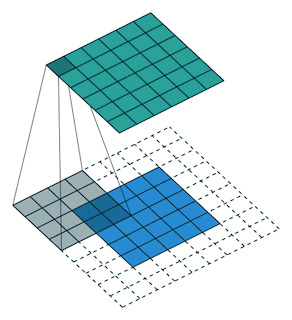

#### **Q7**

Modify your `conv2d` function to take an additional argument `padding` that specifies the number of 0s to add before the first element and after the last element of each dimension before applying the convolution. For example:
$$\text{Padding = 1: }\quad \begin{bmatrix} 2 & 5 \\ -1 & 3 \end{bmatrix} \longrightarrow \begin{bmatrix} 0 & 0 & 0 & 0 \\ 0 & 2 & 5 & 0 \\ 0 & -1 & 3 & 0 \\ 0 & 0 & 0 & 0 \\\end{bmatrix} $$
$$\text{Padding = 2: }\quad \begin{bmatrix} 2 & 5 \\ -1 & 3 \end{bmatrix} \longrightarrow \begin{bmatrix}0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 2 & 5 & 0 & 0 \\ 0 & 0 & -1 & 3 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix} $$

***Hint:** Make sure to account for the change in the output shape!*

In [ ]:
def conv2d(image, kernel, padding=0):
    kernel_size = kernel.shape[-1]
    image_height, image_width = image.shape[-2], image.shape[-1]
    output_height = # YOUR CODE HERE
    output_width = # YOUR CODE HERE

    output = np.zeros(image.shape[:-2] + (output_height, output_width))
    # YOUR CODE HERE
                   
    return output

Let's visualize the same convolution with and without padding.

In [ ]:
# Create an edge detection kernel
kernel = np.array([[ 1,  1,  1],
                   [ 0,  0,  0],
                   [-1, -1, -1]])

# Take just the height and width dimensions of our image
image = data[0][0][0]

# Create the axes for our plots
f, ax = plt.subplots(1, 3,)
ax[0].imshow(image, cmap='Greys_r')
ax[0].set_title('Image')

# Apply our convolution with no padding and plot the result
output_0 = conv2d(image, kernel, padding=0)
ax[1].imshow(output_0, cmap='Greys_r')
ax[1].set_title('Padding=0')

# Apply our convolution with a padding of 10 and plot the result
output_10 = conv2d(image, kernel, padding=10)
ax[2].imshow(output_10, cmap='Greys_r')
ax[2].set_title('Padding=10')

While it is convinient to think of images as being matrices, as we've seen, color images actually have 3 values at each location! A red value, a green value as a blue value as shown below. We call these the color *channels*. 

In [ ]:
import PIL # Pillow
# Load an image
image = np.array(PIL.Image.open('astronaut.jpg'))[..., :3]

# Plot the color image
f, ax = plt.subplots(1, 4, figsize=(8, 3))
ax[0].imshow(image)
ax[0].set_title('Image')

# Plot each color channel separately
ax[1].imshow(image[..., 0], cmap='Greys_r')
ax[1].set_title('Red channel')
ax[2].imshow(image[..., 1], cmap='Greys_r')
ax[2].set_title('Green channel')
ax[3].imshow(image[..., 2], cmap='Greys_r')
ax[3].set_title('Blue channel')

In PyTorch, we'll represent an image with multiple channels as a $\text{Channels (c)} \times \text{Height (h)} \times \text{Width (w)}$ tensor. *Note: this is different from many other libraries, which put the channel dimension last!*. We therefore have a vector, rather than a scalar at each position in the image.

For a 2-dimensional convolution applied to an image with multiple channels, our kernel will also need to have a matching number of channels. In this case, at each step of our convolution, we'll compute a dot product between two channel vectors rather than two scalars.

$$\text{Conv}(\mathbf{X}, \mathbf{K})_{r,c} =  \sum_{i=1}^s\sum_{j=1}^s\sum_{l=1}^c X_{l, r+i,c+j}\ K_{l, i,j} = \sum_{i=1}^s\sum_{j=1}^s X_{:, r+i,c+j}^T\ K_{:, i,j}$$

The following animation shown what this looks like for a 1-dimensional convolution.

<video src="convolution_channels.mp4" controls height=320 title="Title"></video>

#### **Q8**

Modify your (original or padded) `conv2d` function to accept 2 *3-dimensional tensors* with the following shapes:

$$\text{Input: }\quad \text{Channels (c)} \times \text{Height (h)} \times \text{Width (w)}$$
$$\text{Kernel: }\quad \text{Channels (c)} \times \text{Size (s)} \times \text{Size (s)}$$

The result should be a *2-dimensional matrix*, such that each entry follows the equation above.

In [ ]:
def conv2d(image, kernel):
    kernel_size = kernel.shape[-1]
    image_height, image_width = image.shape[-2], image.shape[-1]
    output_height = # YOUR CODE HERE
    output_width = # YOUR CODE HERE

    output = np.zeros( (output_height, output_width))
    # YOUR CODE HERE
    #               
    return output

Let's try applying using our convolution function on a color image! Below we'll load an image using the Python Pillow library and use our function to compute a convolution, using an *edge detection* kernel.

In [ ]:
import PIL # Pillow

# Create an edge detection kernel
kernel = np.array([[ 1,  1,  1],
                   [ 0,  0,  0],
                   [-1, -1, -1]])
# Repeat it for the red, green and blue channels
kernel_vertical = np.stack([kernel, kernel, kernel])
# Create a transposed version as well
kernel_horizontal = np.stack([kernel.T, kernel.T, kernel.T])

# Load an image and convert it to a numpy array
image = np.array(PIL.Image.open('astronaut.jpg'))[..., :3]

# Create the axes for our plots
f, ax = plt.subplots(1, 4, figsize=(8, 3))
ax[0].imshow(image)

# Convert our image from (height x width x channels) to (channels x height x width)
image = image.transpose(2, 0, 1)

# Apply our convolution and plot the result
output_vertical = conv2d(image, kernel_vertical)
ax[1].imshow(output_vertical, cmap='Greys_r')

# Apply our transposed convolution and plot the result
output_horizontal = conv2d(image, kernel_horizontal)
ax[2].imshow(output_horizontal, cmap='Greys_r')

# Apply a averaging (blur) kernel
output_mean = conv2d(image, np.ones_like(kernel_horizontal))
ax[3].imshow(output_mean, cmap='Greys_r')

Typically we want to compute several convolutions at once, such that our output also has multiple channels, as illustrated below in 1 dimension. (For a 2-dimensional visualization, check out [this website](https://poloclub.github.io/cnn-explainer/))

<video src="convolution_output_channels.mp4" controls height=320 title="Title"></video>

 We will typically also want to be able to apply our convolutions to multiple inputs at once, as in a batch. For this reason the `Conv2d` function in PyTorch actually expects 2 *4-dimensional tensors* with the following structure:

$$\text{Input: }\quad \text{Observations (N)} \times \text{Channels (c)} \times \text{Height (h)} \times \text{Width (w)}$$
$$\text{Kernel: }\quad \text{Output channels (o)} \times \text{Channels (c)} \times  \text{Size (s)} \times \text{Size (s)}$$

In this case, at each corresponding location between our input and kernel, we will multiply an $N \times c$ input matrix with the transpose of a $o \times c$ weight matrix to produce an $N \times o$ matrix. In total our result will have the following shape:

$$\text{Output: }\quad \text{Observations (N)} \times \text{Output channels (o)} \times \text{Output height (h)} \times \text{Output width (w)}$$

We can define each entry of the output with the following equation:

$$\text{Conv}(\mathbf{X}, \mathbf{K})_{n,k,r,c} =  \sum_{i=1}^s\sum_{j=1}^s\sum_{l=1}^c X_{n,l, r+i,c+j}\ K_{k, l, i,j}$$


#### **Q9:**
Implement a new version of `conv2d` that takes in a *4-dimension* input array and a *4-dimensional* kernel array and computes the (batched) convolution function described above.

In [ ]:
def conv2d(image, kernel):
    '''
    '''
    kernel_size = kernel.shape[-1]
    output_channels = kernel.shape[0]
    image_height, image_width = image.shape[-2], image.shape[-1]
    output_height = # YOUR CODE HERE
    output_width = # YOUR CODE HERE

    output = np.zeros(image.shape[:-3] + (output_channels, output_height, output_width))
    # YOUR CODE HERE
                   
    return output

PyTorch provides a convinient way to load *batches* of images from a dataset via the `DataLoader` class. The dataloader will automatically group images and labels into tensors for us!

In [ ]:
from torch.utils.data import DataLoader

loader = DataLoader(data,            # The dataset
                    batch_size=8,    # The batch size
                    shuffle=True,    # Tell PyTorch to randomize the order of the data
                    )

for batch in loader:
    images, labels = batch
    print('Image batch shape:', images.shape)
    print('Label batch shape:', labels.shape)
    break

Now we can try applying 3 kernels to a batch of data simultaniously. 

In [ ]:
# Create an edge detection kernel
kernel = np.array([[ 1,  1,  1],
                   [ 0,  0,  0],
                   [-1, -1, -1]])
# Repeat it for the red, green and blue channels
kernel_vertical = np.stack([kernel])
# Create a transposed version as well
kernel_horizontal = np.stack([kernel.T])
# Create a blur kernel
kernel_blur = np.ones_like(kernel_horizontal)

# Put all 3 kernels together into a single array
kernel = np.stack([kernel_vertical, kernel_horizontal, kernel_blur])
output = conv2d(images, kernel)

# Create the axes for our plots
f, ax = plt.subplots(1, 5, figsize=(10, 3))
ax[0].imshow(images[0][0], cmap='Greys_r')
ax[0].set_title('Image')

# Plot the result of the first kernel
ax[1].imshow(output[0][0], cmap='Greys_r')
ax[1].set_title('Kernel 1')

# Plot the result of the second kernel
ax[2].imshow(output[0][1], cmap='Greys_r')
ax[2].set_title('Kernel 2')

# Plot the result of the third kernel
ax[3].imshow(output[0][2], cmap='Greys_r')
ax[3].set_title('Kernel 3')

# Plot the result of all three kernels as the rgb channels of an image
full_output = output[0].transpose(1, 2, 0)
full_output = full_output - full_output.min()
full_output = full_output / full_output.max()
ax[4].imshow(full_output)
ax[4].set_title('All kernels')

# Part 2: CNNs in PyTorch

The `nn` module from PyTorch includes built-in support for convolutional layers that we can use in the same way that we would use `nn.Linear` layers. In particular the `nn.Conv2d` layer will perform 2-dimensional convolutions over an image input. `nn.Conv2d` expects the input to have the *4-dimensional* shape we introduced above:

$$\text{Input: }\quad \text{Observations (N)} \times \text{Channels (c)} \times \text{Height (h)} \times \text{Width (w)}$$

A simple implementation of the `nn.Conv2d` module might look something like this: 

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F


class Conv2D(nn.Module):
    def __init__(self, in_dimensions, out_dimensions, kernel_size):
        super().__init__()
        # Create a kernel (weight) parameter and a bias parameter
        self.kernel = nn.Parameter(torch.randn(out_dimensions, in_dimensions, kernel_size, kernel_size) / np.sqrt(in_dimensions))
        self.bias = nn.Parameter(torch.zeros((1, out_dimensions, 1, 1)))

    def forward(self, x):
        # The PyTorch equivalent of the conv2d function we wrote!
        print(x.shape, self.kernel.shape, self.bias.shape)
        return F.conv2d(x, self.kernel) + self.bias
    

We can use it as we would any other layer, as long as we give it the right input shape. Here we'll load an image into PyTorch and apply a very simple random convolution to it.

In [ ]:
output = Conv2D(1, 3, 3)(images)

# Convert to numpy
output = output.detach().numpy()

# Create the axes for our plots
f, ax = plt.subplots(1, 5, figsize=(10, 3))
ax[0].imshow(images[0][0], cmap='Greys_r')
ax[0].set_title('Image')

# Plot the result of the first kernel
ax[1].imshow(output[0][0], cmap='Greys_r')
ax[1].set_title('Kernel 1')

# Plot the result of the second kernel
ax[2].imshow(output[0][1], cmap='Greys_r')
ax[2].set_title('Kernel 2')

# Plot the result of the third kernel
ax[3].imshow(output[0][2], cmap='Greys_r')
ax[3].set_title('Kernel 3')

# Plot the result of all three kernels as the rgb channels of an image
full_output = output[0].transpose(1, 2, 0)
full_output = full_output - full_output.min()
full_output = full_output / full_output.max()
ax[4].imshow(full_output)
ax[4].set_title('All kernels')


Another important layer that we'll need for convolutional neural networks is the *max-pooling layer*. Recall that max-pooling is similar to a convolution, but rather than taking a dot product between a kernel and a window of the input, we simply take the maximum value in the window of an input. In the 1-dimensional case this looks like:

<video src="convolution_max.mp4" controls height=320 title="Title"></video>

1-dimension max-pooling with a stride of 1 could be implemented as:

In [ ]:
def maxpool1d(sequence, pool_size=3):
    sequence_length = sequence.shape[0]
    output_length = sequence_length - pool_size + 1
    
    output = np.ones((output_length,)) * -np.inf
    for i in range(output_length):
        for k in range(pool_size):
            output[i] = np.maximum(output[i], sequence[i + k])
    return output

Recall that the *stride* of a pooling (or convolutional) layer specifies to take only 1 in every *stride* outputs. We can use this to *subsample* our sequence or image, producing a lower resolution version as shown below in 1-dimension.

<video src="convolution_strided.mp4" controls height=320 title="Title"></video>

In 2-dimensions it looks like:

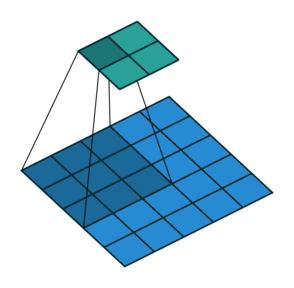

#### **Q10**

Modify the `maxpool1d` function above to take a `stride` argument. For example, if the output of a maxpool is:
$$\text{Output (stride 1): }\begin{bmatrix}5 & 1 & 7 & 4 & 3 & 8 & 2 & 9 & 6 \end{bmatrix}$$
Then the output with stride = 2 should be:
$$\text{Output (stride 2): }\begin{bmatrix}5  & 7  & 3  & 2 & 6 \end{bmatrix}$$
In gerneal the length of the output should be:
$\text{Size} \longrightarrow \big\lfloor\frac{\text{Size}}{\text{Stride}} \big\rfloor$

In [ ]:
def maxpool1d(sequence, pool_size=3, stride=1):
    sequence_length = sequence.shape[0]
    output_length = # YOUR CODE HERE
    
    output = np.ones((output_length,)) * -np.inf
    # YOUR CODE HERE
    
    return output

In PyTorch we can use the `nn.MaxPool2D` layer to perform max-pooling within a neural network. We can perform the similar *average pooling* operation using `nn.AvgPool2D`. Average pooling simply takes the average over a window rather than the max. Below we show how to use both layers to lower the resolution of an image.

In [ ]:
# Create the axes for our plots
f, ax = plt.subplots(1, 5, figsize=(10, 3))
ax[0].imshow(images[0][0], cmap='Greys_r')
ax[0].set_title('Image')

# Plot the result of the first kernel
ax[1].imshow(nn.MaxPool2d(2, 1)(images)[0][0], cmap='Greys_r')
ax[1].set_title('Maxpool\n size=2, stride=1')

# Plot the result of the first kernel
ax[2].imshow(nn.MaxPool2d(2, 2)(images)[0][0], cmap='Greys_r')
ax[2].set_title('Maxpool\n size=2, stride=2')

# Plot the result of the first kernel
ax[3].imshow(nn.AvgPool2d(2, 1)(images)[0][0], cmap='Greys_r')
ax[3].set_title('Avgpool\n size=2, stride=1')

# Plot the result of the first kernel
ax[4].imshow(nn.AvgPool2d(2, 2)(images)[0][0], cmap='Greys_r')
ax[4].set_title('Avgpool\n size=2, stride=2')


The final new useful layer we'll introduce is the *flatten* layer, which is implemented in `nn.Flatten`. This layer takes in a *4-dimensional* batch of images and *flattens* it into *2-dimensional* matrix.

$$\text{Input: }\quad \text{Observations (N)} \times \text{Channels (c)} \times \text{Height (h)} \times \text{Width (w)}$$
$$ \longrightarrow \text{Output: }\quad \text{Observations (N)} \times \text{Total features } (chw)$$ 

We can implement a simple version of this layer as follows:


In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.reshape(x.shape[:-3] + (-1,))
    

print('Shape of image batch:', images.shape)
print('Shape of flattened batch:', Flatten()(images).shape)

This flatten layer allows us to use `nn.Linear` layers following our convolutional layers.

We can now put everything together to make a very simple convolutional network with a single convolutional layer and a single linear layer:

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, 5, padding=2),  # Convolutional layer with 1 input channel, 6 output channels and a kernel size of 5
    nn.Tanh(),                      # Tanh activation function
    nn.AvgPool2d(2, 2),             # Average pooling with a pool size of 2 and a stride of 2
    nn.Flatten(),                   # Flatten the output of AvgPool. to be batch x 1176
    nn.Linear(1176, 10),            # Final linear layer to predict 1 of 10 classes.
)

We'll use the provided `run_model` function (from the last homework) to train and evaluate this model on the FashionMNIST dataset.

In [ ]:
run_model(data_path, model)

As we saw in class, often convolutional neural network architectures are presented as diagrams that specify the size and number of convolutions at each layer. Below is a diagram describing one of the most famous convolutional neural network archtectures: LeNet-5 (named after on of it's inventors Yann LeCun).

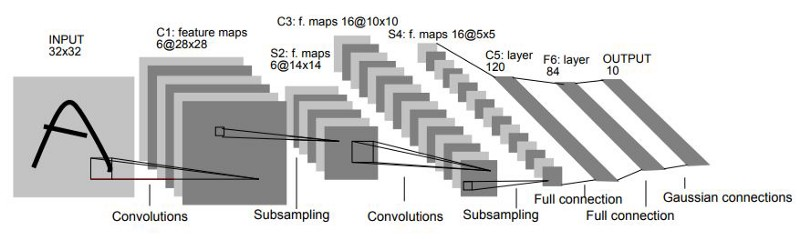

#### **Q11:**

Implement a version of the LeNet-5 architecture shown above. Note that there are some crucial details missing from the figure, such as: the activation function to use and what kind of subsampling to use. Feel free to make your own choices for these. For activations you could use `nn.Tanh` or `nn.ReLU`. For subsampling you could use `nn.MaxPool2d` or `nn.AvgPool2d` with appropriate strides.

*Note that the size of our inputs is 28x28, not the 32x32 in the figure above, you'll need this information to compute the appropriate number of inputs for the first linear layer.*

In [ ]:
model = nn.Sequential(
# YOUR CODE HERE
)

run_model(data_path, model)

#### **Q12:**

Modify the network you just created such that the validation accuracy is above 90%. You may need to experiment a bit to find a network that works. Feel free to change the activations, the number and size of layers and the pooling. You may also use other layers that we've learned about, such as: `nn.Dropout` and `nn.BatchNorm2d`.

*If your LeNet-5 implementation already achieved over 90% accuracy, try to improve on its accuracy by at least 1%. If it takes more than a few minutes to achieve over 90% accuracy, just make a note of what you tried and the best accuracy you got!*

In [ ]:
model = nn.Sequential(
# YOUR CODE HERE
)

run_model(data_path, model)